# CCXT Market Data Tutorial: Getting Data from Binance

This notebook demonstrates how to use the CCXT library to retrieve cryptocurrency market data from Binance, including:
1. Getting current market data
2. Fetching historical data with various timeframes
3. Streaming real-time data

## Setup and Installation

First, let's install the required packages and import the necessary libraries.

In [1]:
# Install required packages
!pip install ccxt pandas matplotlib websocket-client

  Using cached pandas-2.2.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached yarl-1.20.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (72 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.6.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (16 kB)
  Using cached multidict-6.4.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.3 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached propcache-0.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached numpy-2.2.5-cp313-cp313-macosx_14_

In [4]:
# Import necessary libraries
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import json


## Initializing the Binance Exchange

CCXT makes it easy to connect to Binance. We'll create an instance of the Binance exchange with rate limiting enabled.

In [5]:

class CryptoExchange():

    def describe(self):
        """
        Override the describe method to add custom properties.
        """
        return super().describe()
    

    def get_exchanges(self):
        """
        Get a list of all exchanges available in ccxt.
        """
        exchanges = ccxt.exchanges
        return exchanges


    def init_exchange(self,exchange_id, api_key, api_secret):
        """
        Initialize a specific exchange by its ID.
        """
        try:
            self.exchange = getattr(ccxt, exchange_id)()
            self.exchange.apiKey = api_key
            self.exchange.secret = api_secret
            return self.exchange
        except AttributeError:
            print(f"Exchange {exchange_id} not found.")
            return None
    

    def is_exchange_active(self):

        """
        Check if the exchange is operational.
        """
        exchange_info = self.exchange.fetch_status()
        
        # Check if the exchange is operational
        if exchange_info['status'] == 'ok':
            return True
        else:
            return False
    


    def get_exchange_info(self, exchange_id):
        """
        Get information about a specific exchange.
        """
        try:
            exchange_info = self.exchange.fetch_status()
            server_time = self.exchange.fetchTime()

            markets = self.exchange.load_markets()
            currencies = self.exchange.fetch_currencies()

            self.markets = markets
            self.currencies = currencies

            crypto_currencies=[]
            fiat_currencies=[]
            for currency in currencies.values():
                if currency['type'] == 'crypto' and currency['active']:
                    crypto_currencies.append(currency['code'])
                if currency['type'] == 'fiat' and currency['active']:
                    if currency['info']['isLegalMoney']:
                        fiat_currencies.append(currency['code'])

            print(fiat_currencies)
            final_crypto_currencies = []
            final_fiat_currencies = []
            for market in markets.values():
                if market['active'] and market['info'].get("status","") == 'TRADING':
                    if market['base'] in crypto_currencies or market['quote'] in crypto_currencies:
                        final_crypto_currencies.append(market["id"])
                    
                    if market['base'] in fiat_currencies or market['quote'] in fiat_currencies:
                        final_fiat_currencies.append(market["id"])
                    
        
            self.exchange_info = {
                'id': exchange_id,
                'name': exchange_id,
                'updated': server_time,
                'crypto_currencies': len(final_crypto_currencies),
                'fiat_currencies': len(final_fiat_currencies),
                'total_markets': len(final_crypto_currencies) + len(final_fiat_currencies),
                'crypto_currencies_list': final_crypto_currencies,
                'fiat_currencies_list': final_fiat_currencies,
                'status': exchange_info['status'],
                'server_time': datetime.fromtimestamp(server_time / 1000).strftime('%Y-%m-%d %H:%M:%S'),
                'server_time_unix': server_time,
                'active': self.is_exchange_active(),
            }
        
            return self.exchange_info
        except Exception as e:
            import traceback
            traceback.print_exc()
            print(f"Error fetching info for {exchange_id}: {e}")
            return None


    
    def fetch_historical_data(self, symbol, timeframe, start_timestamp, end_timestamp):
        """
        Fetch historical OHLCV data in batches, respecting exchange limits.
        
        Args:
            symbol (str): Trading pair symbol (e.g., 'BTC/USDT')
            timeframe (str): Timeframe for candles (e.g., '1m', '1h', '1d')
            start_timestamp (str or int): Start time as timestamp or ISO 8601 string
            end_timestamp (str or int): End time as timestamp or ISO 8601 string
            
        Returns:
            DataFrame: Pandas DataFrame with OHLCV data or empty DataFrame if no data
        """
        all_candles = []
        
        
        # Convert dates to timestamps
        start_timestamp = self.exchange.parse8601(start_timestamp)
        end_timestamp = self.exchange.parse8601(end_timestamp)
        limit = 1000

        since = start_timestamp
        print(f"Fetching {symbol} {timeframe} data from {datetime.fromtimestamp(start_timestamp/1000)} to {datetime.fromtimestamp(end_timestamp/1000)}")
        
        while since < end_timestamp:
            print(f"Fetching batch starting at {datetime.fromtimestamp(since/1000)}")
            candles = self.exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            
            if (not candles) or len(candles)<=0:
                print("No more candles returned",len(candles))
                break
                
            print(f"Received {len(candles)} candles",since)
            all_candles.extend(candles)

            since = int(candles[-1][0]) + 1  # Next timestamp after the last received candle
            
            # If we received less than the requested limit, we've reached the end
            if len(candles) < 1000:
                print("Received less than 1000 candles, reached the end")
                break
                
            # Respect the rate limit
            time.sleep(self.exchange.rateLimit / 1000)  
        
        # Convert to DataFrame
        # Check if all_candles is a list of lists (expected structure for DataFrame)
        if all_candles:
            if isinstance(all_candles[0], list):
                print("Creating DataFrame from list of lists")
                df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                return df
            else:
                # If all_candles is a list of DataFrames, concatenate them
                print("Concatenating DataFrames")
                print(all_candles)
                df = pd.concat(all_candles, ignore_index=True)
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                return df
        else:
            return pd.DataFrame()

    def get_tickers(self, symbols=['BTC/USDT']):
        """
        Get tickers for specified markets or all markets on the exchange.
        
        Args:
            symbols (list, optional): List of symbols to get tickers for (e.g., ['BTC/USDT', 'ETH/USDT'])
            
        Returns:
            dict: Dictionary of ticker data by symbol or None if an error occurs
        """
        try:
            rdata = {}
            # Fix: Changed fetchTickets to fetch_tickers (correct method name)
            tickers = self.exchange.fetch_tickers(symbols)
            for ticker in tickers.values():
                data={}

                data['symbol'] = ticker['symbol']
                data['timestamp'] = datetime.fromtimestamp(ticker['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S')
                data['timestamp_unix'] = ticker['timestamp']
                
                # Store pricing information in a structured format
                data['pricing_information'] = {
                    'high': ticker['high'],
                    'low': ticker['low'],
                    'open': ticker['open'],
                    'last': ticker['last'],
                    'close': ticker['close'],
                    'prev_close': ticker['previousClose'],
                }

                data['order_book'] = {
                    'bid': ticker['bid'],
                    'ask': ticker['ask'],
                    'bid_volume': ticker['bidVolume'],
                    'ask_volume': ticker['askVolume'],
                }

                data['volume'] = {
                    'base_volume': ticker['baseVolume'],
                    'quote_volume': ticker['quoteVolume'],
                }


                data['change'] = {
                    'price_change': ticker['change'],
                    'percentage': ticker['percentage'],
                    'average': ticker['average'],
                    'vwap': ticker['vwap'],

                }
                data['last_trade'] = {
                    'timestamp': ticker['timestamp'],
                    'price': ticker['last'],
                    'amount': ticker['last'],
                }

                data['symbol'] = ticker['symbol'].replace("/", "_")
                rdata[ticker['symbol']] = data
                #print(f"Ticker data for {ticker['symbol']} fetched successfully.")
                #print(f"Ticker data: {data}")

            return rdata
        except Exception as e:
            print(f"Error fetching tickers: {e}")
            return None


    def get_order_book(self, symbol, limit=5, best=False):
        """
        Get the order book for a specific symbol.
        
        Args:
            symbol (str): Trading pair symbol (e.g., 'BTC/USDT')
            limit (int): How many price levels to include
            best (bool): If True, only get best bid and ask
            
        Returns:
            dict: Order book information or None if an error occurs
        """
        try:
            order_book = {}  # Initialize order_book dictionary here to fix reference before assignment
            
            if best:
                # Get only best bid and ask
                ticker = self.exchange.fetch_bids_asks(symbol)
                order_book['symbol'] = symbol
                order_book['datetime'] = ticker['timestamp']
                order_book['linux_timestamp'] = ticker['timestamp']
                order_book['bids'] = [ticker['bid'], ticker['bidVolume']]
                order_book['asks'] = [ticker['ask'], ticker['askVolume']]
                order_book['spread'] = order_book['asks'][0] - order_book['bids'][0]
                order_book['average_bid'] = None
                order_book['average_ask'] = None
                order_book['top_bid'] = order_book['bids'][0]
                order_book['top_ask'] = order_book['asks'][0]
                order_book['weighted_bid'] = None
                order_book['weighted_ask'] = None
                order_book['timestamp'] = ticker['timestamp']
            else:
                # Get full order book
                order_book_data = self.exchange.fetch_order_book(symbol, limit)
                order_book = {
                    'symbol': symbol,
                    'timestamp': order_book_data['timestamp'],
                    'datetime': datetime.fromtimestamp(order_book_data['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S') if order_book_data['timestamp'] else None,
                    'bids': order_book_data['bids'],
                    'asks': order_book_data['asks'],
                }

            if not order_book.get('timestamp'):  # Use .get() to avoid KeyError
                # print("No order book data available.")
                order_book['timestamp'] = time.time() * 1000

                order_book['top_bid'] = order_book['bids'][0] if order_book['bids'] else None
                order_book['top_ask'] = order_book['asks'][0] if order_book['asks'] else None
                order_book['average_bid'] = sum([bid[0] for bid in order_book['bids']]) / len(order_book['bids']) if order_book['bids'] else None
                order_book['average_ask'] = sum([ask[0] for ask in order_book['asks']]) / len(order_book['asks']) if order_book['asks'] else None
                order_book['spread'] = order_book['top_ask'][0] - order_book['top_bid'][0] if order_book['top_bid'] and order_book['top_ask'] else None
                order_book['weighted_bid'] = sum([bid[0] * bid[1] for bid in order_book['bids']]) / sum([bid[1] for bid in order_book['bids']]) if order_book['bids'] else None
                order_book['weighted_ask'] = sum([ask[0] * ask[1] for ask in order_book['asks']]) / sum([ask[1] for ask in order_book['asks']]) if order_book['asks'] else None
                order_book['symbol'] = symbol
            


            return order_book
        except Exception as e:
            print(f"Error fetching order book for {symbol}: {e}")
            return None
        
    def get_trades(self,symbol, since=None, limit=5):
        """
        Get recent trades for a specific symbol.
        """
        try:
            trades = self.exchange.fetch_trades(symbol, since, limit)

            # Create a DataFrame for better visualization
            trades_df = pd.DataFrame([
                {
                    'timestamp': datetime.fromtimestamp(trade['timestamp'] / 1000),
                    'linux_timestamp': trade['timestamp'],
                    'side': trade['side'],
                    'price': trade['price'],
                    'amount': trade['amount'],
                    'cost': trade['cost'],
                    'total' : trade['price'] * trade['amount'],
                    'id': trade['id']
                } for trade in trades
            ])

            result={}
            result['symbol'] = symbol
            result['timestamp'] = trades_df['timestamp'].iloc[0]
            result['linux_timestamp'] = trades_df['linux_timestamp'].iloc[0]
            result['buy']= trades_df[trades_df['side'] == 'buy']
            result['sell'] = trades_df[trades_df['side'] == 'sell']
            result['buy_total'] = result['buy']['total'].sum()
            result['sell_total'] = result['sell']['total'].sum()
            result['buy_count'] = len(result['buy'])
            result['sell_count'] = len(result['sell'])
            result['buy_average'] = result['buy']['price'].mean()
            result['sell_average'] = result['sell']['price'].mean()
            result['buy_weighted_average'] = result['buy']['total'].sum() / sum(result['buy']['amount']) if len(result['buy']) > 0 else None
            result['sell_weighted_average'] = result['sell']['total'].sum() / sum(result['sell']['amount']) if len(result['sell']) > 0 else None


 
            return result
        except Exception as e:
            print(f"Error fetching trades for {symbol}: {e}")
            return None
        
    def get_balance(self):
        """
        Get the balance of the account.
        """
        try:
            balance = self.exchange.fetch_balance()
            return balance
        except Exception as e:
            print(f"Error fetching balance: {e}")
            return None
        
    
    def get_orders(self, symbol, order_type='open', order_id=None):
        """
        Get orders for a specific symbol.
        
        Args:
            symbol (str): Trading pair symbol (e.g., 'BTC/USDT')
            order_type (str): Type of orders to get ('open', 'closed', 'all')
            order_id (str, optional): ID of specific order to fetch
            
        Returns:
            list or dict: List of orders or specific order info if order_id is provided
        """
        try:
            # If order_id is provided, fetch the specific order
            if order_id and order_type == 'open':
                return self.exchange.fetch_open_order(order_id, symbol)
            
            # Otherwise fetch orders based on type
            if order_type == 'open':
                return self.exchange.fetch_open_orders(symbol)
            elif order_type == 'closed':
                return self.exchange.fetch_closed_orders(symbol)
            elif order_type == 'all':
                return self.exchange.fetch_orders(symbol)
            else:
                raise ValueError("Invalid order type. Use 'open', 'closed', or 'all'.")
        except Exception as e:
            print(f"Error fetching open orders for {symbol}: {e}")
            return None


In [ ]:
%export API_KEY="your_api_key_here"
%export API_SECRET="your_api_secret_here"

In [ ]:

import os
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()
# Get the API key and secret from environment variables
api_key = os.getenv("API_KEY")
api_secret = os.getenv("API_SECRET")
cx=CryptoExchange()

cx.init_exchange("binance", api_key, api_secret)



ccxt.binance()

## Getting Current Market Data

### Fetching Available Markets

In [11]:
info=cx.get_exchange_info("binance")
clist=info['crypto_currencies_list'][:5]

print("total markets ", info["total_markets"])
print("total crypto currencies ", info["crypto_currencies"]) 
print("total fiat currencies ", info["fiat_currencies"]) 
 # Fixed typo and removed 'bj'
print("first five crypto currencies ", clist)
print("first five fiat currencies ", info['fiat_currencies_list'][:5])


['BRL', 'ZAR', 'MXN', 'COP', 'TRY', 'EUR', 'RON', 'PLN', 'ARS', 'CZK', 'UAH', 'JPY']
total markets  2235
total crypto currencies  1871
total fiat currencies  364
first five crypto currencies  ['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH']
first five fiat currencies  ['BTCTRY', 'BNBTRY', 'ETHTRY', 'XRPTRY', 'USDTTRY']


### Getting Current Ticker Information

CCXT provides a simple way to fetch current market data for specific trading pairs. The `fetch_ticker()` method returns comprehensive information about a trading pair's current market state, including:

- **Price Information**: Current price, open, high, low, close values
- **Volume Data**: Base and quote volume in the last 24 hours
- **Price Changes**: Absolute and percentage changes over 24 hours
- **Order Book Snapshot**: Best bid/ask prices and volumes
- **Timestamps**: When the data was recorded
- **Market Identifiers**: Symbol and other market identifiers


This information is essential for market analysis, calculating technical indicators, and making trading decisions. You can fetch a single ticker or use `fetch_tickers()` to retrieve information for multiple symbols simultaneously.

In [ ]:
# Get current ticker information for BTC/USDT
ticker = cx.get_tickers(['LTCBTC'])


# Display full ticker information
print("\nFull Ticker Information:",ticker)
for key, value in ticker.items():
    print(f"{key}: {value}")

Ticker data for LTC/BTC fetched successfully.
Ticker data: {'symbol': 'LTC_BTC', 'timestamp': '2025-05-10 15:28:25', 'timestamp_unix': 1746871105203, 'pricing_information': {'high': 0.001038, 'low': 0.000949, 'open': 0.000954, 'last': 0.000998, 'close': 0.000998, 'prev_close': 0.000954}, 'order_book': {'bid': 0.000997, 'ask': 0.000998, 'bid_volume': 14.278, 'ask_volume': 268.938}, 'volume': {'base_volume': 41799.859, 'quote_volume': 41.46976336}, 'change': {'price_change': 4.4e-05, 'percentage': 4.612, 'average': 0.000976, 'vwap': 0.0009921}, 'last_trade': {'timestamp': 1746871105203, 'price': 0.000998, 'amount': 0.000998}}

Full Ticker Information: {'LTC/BTC': {'symbol': 'LTC_BTC', 'timestamp': '2025-05-10 15:28:25', 'timestamp_unix': 1746871105203, 'pricing_information': {'high': 0.001038, 'low': 0.000949, 'open': 0.000954, 'last': 0.000998, 'close': 0.000998, 'prev_close': 0.000954}, 'order_book': {'bid': 0.000997, 'ask': 0.000998, 'bid_volume': 14.278, 'ask_volume': 268.938}, 'volu

# Fetching Multiple Tickers with CCXT

CCXT allows you to fetch information for multiple trading pairs in a single API call, which is more efficient than making separate requests for each ticker. Using the `exchange.fetch_tickers()` method, you can retrieve data for multiple symbols simultaneously.

## Fetching Multiple Tickers

You can fetch multiple tickers in two ways:

1. **Fetch specific symbols** - Pass an array of symbols:
    ```python
    tickers = binance.fetch_tickers(['BTC/USDT', 'ETH/USDT', 'LTC/BTC'])
    ```

2. **Fetch all available tickers**:
    ```python
    all_tickers = binance.fetch_tickers()
    ```

## Ticker Limits

- **Binance** has a limit of approximately 100 symbols per request
- When fetching all tickers, be aware of rate limits - Binance may throttle requests if too many are made too quickly . Use the exchange's rate limiting options (`enableRateLimit: true`) to avoid being temporarily banned
- For very large markets like Binance (with 2000+ trading pairs), fetching all tickers might be slower than targeted requests . Consider implementing pagination or batching for large numbers of symbols
- Only request the tickers you need to minimize data transfer



In [109]:
# Get current ticker information for BTC/USDT
tickers = cx.get_tickers(['LTCBTC','ETHBTC'])


# Display full ticker information
print("\nFull Ticker Information:")
for key, value in tickers.items():
    #print(f"{key}: {value}")
    print("--------------------------------------------------------")
    #print(f"{key}: {value}")
    for key1, value1 in value.items():
        print(f"{key1}: {value1}")


Full Ticker Information:
--------------------------------------------------------
symbol: ETH_BTC
timestamp: 2025-05-10 21:43:50
timestamp_unix: 1746893630984
pricing_information: {'high': 0.02372, 'low': 0.02235, 'open': 0.02235, 'last': 0.02362, 'close': 0.02362, 'prev_close': 0.02235}
order_book: {'bid': 0.02361, 'ask': 0.02362, 'bid_volume': 24.2876, 'ask_volume': 33.9717}
volume: {'base_volume': 38257.2509, 'quote_volume': 881.88649954}
change: {'price_change': 0.00127, 'percentage': 5.682, 'average': 0.022985, 'vwap': 0.02305149}
last_trade: {'timestamp': 1746893630984, 'price': 0.02362, 'amount': 0.02362}
--------------------------------------------------------
symbol: LTC_BTC
timestamp: 2025-05-10 21:43:50
timestamp_unix: 1746893630833
pricing_information: {'high': 0.001038, 'low': 0.000956, 'open': 0.000957, 'last': 0.00099, 'close': 0.00099, 'prev_close': 0.000956}
order_book: {'bid': 0.000991, 'ask': 0.000992, 'bid_volume': 17.325, 'ask_volume': 401.649}
volume: {'base_volu

## Fetching Historical Market Data

CCXT provides a unified interface for retrieving historical OHLCV (Open, High, Low, Close, Volume) data.

Binance supports various timeframes:
- 1m (1 minute)
- 3m (3 minutes)
- 5m (5 minutes)
- 15m (15 minutes)
- 30m (30 minutes)
- 1h (1 hour)
- 2h (2 hours)
- 4h (4 hours)
- 6h (6 hours)
- 8h (8 hours)
- 12h (12 hours)
- 1d (1 day)
- 3d (3 days)
- 1w (1 week)
- 1M (1 month)


### Data Availability and Limits

- **Historical Data Range**: Binance typically provides data from around 2017 onwards, depending on when the trading pair was listed
- **Single API Call Limit**: Maximum 1000 candles per request
- **Rate Limits**: 
    - Binance imposes rate limits of 1200 requests per minute
    - Weight-based system assigns different weights to different endpoints
    - Using `enableRateLimit: true` option helps avoid being temporarily banned
 - **Data Retention**: 
    - Recent timeframes (1m, 3m, 5m): ~7 days
    - 15m: ~30 days
    - Larger timeframes: stored for longer periods
    - 1h and above: generally available from listing date

For retrieving large historical datasets, you may need to implement pagination by making multiple requests with updated `since` parameters.

### Fetch and Analyze 1-hour Candles

In [13]:

start_date = '2025-01-01T00:00:00Z'
end_date = '2025-01-01T23:59:59Z'



print(f"Fetching data from {start_date} to {end_date}")
#print(f"Start timestamp: {start_timestamp}, End timestamp: {end_timestamp}")
fetch_historical_data = cx.fetch_historical_data('BTC/USDT', '1h', start_date, end_date)


if not fetch_historical_data.empty:
    print("Data fetched successfully.")
else:
    print("No data fetched.")

print(fetch_historical_data)

# Display information
print(f"Retrieved {len(fetch_historical_data)} hourly candles")
print("\nFirst 5 hourly candles:")
print(fetch_historical_data.head())

# Calculate some basic statistics
print("\nBasic Statistics:")
print(fetch_historical_data.describe())

Fetching data from 2025-01-01T00:00:00Z to 2025-01-01T23:59:59Z
Fetching BTC/USDT 1h data from 2025-01-01 05:30:00 to 2025-01-02 05:29:59
Fetching batch starting at 2025-01-01 05:30:00
Received 1000 candles 1735689600000
Creating DataFrame from list of lists
Data fetched successfully.
              timestamp      open      high       low     close      volume
0   2025-01-01 00:00:00  93576.00  94509.42  93489.03  94401.14   755.99010
1   2025-01-01 01:00:00  94401.13  94408.72  93578.77  93607.74   586.53456
2   2025-01-01 02:00:00  93607.74  94105.12  93594.56  94098.91   276.78045
3   2025-01-01 03:00:00  94098.90  94098.91  93728.22  93838.04   220.99302
4   2025-01-01 04:00:00  93838.04  93838.04  93500.00  93553.91   279.46909
..                  ...       ...       ...       ...       ...         ...
995 2025-02-11 11:00:00  97961.24  98232.91  97894.38  98151.52   302.01527
996 2025-02-11 12:00:00  98151.51  98158.89  97680.49  97766.13   550.95842
997 2025-02-11 13:00:00  97766

### Visualizing Historical Data

In [14]:
def plot_ohlcv(df, title):
    """Plot OHLCV data with close price and volume."""
    # Create a figure with two subplots (price and volume)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot close price on the first subplot
    ax1.plot(df['timestamp'], df['close'], label='Close Price', color='blue')
    ax1.set_title(f"{title} - Price", fontsize=14)
    ax1.set_ylabel('Price (USDT)', fontsize=12)
    ax1.grid(True)
    ax1.legend()
    
    # Plot volume on the second subplot
    ax2.bar(df['timestamp'], df['volume'], label='Volume', color='green', alpha=0.6)
    ax2.set_title(f"{title} - Volume", fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.grid(True)
    ax2.legend()
    
    # Rotate x-axis labels for better readability
    plt.setp(ax1.get_xticklabels(), rotation=45)
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

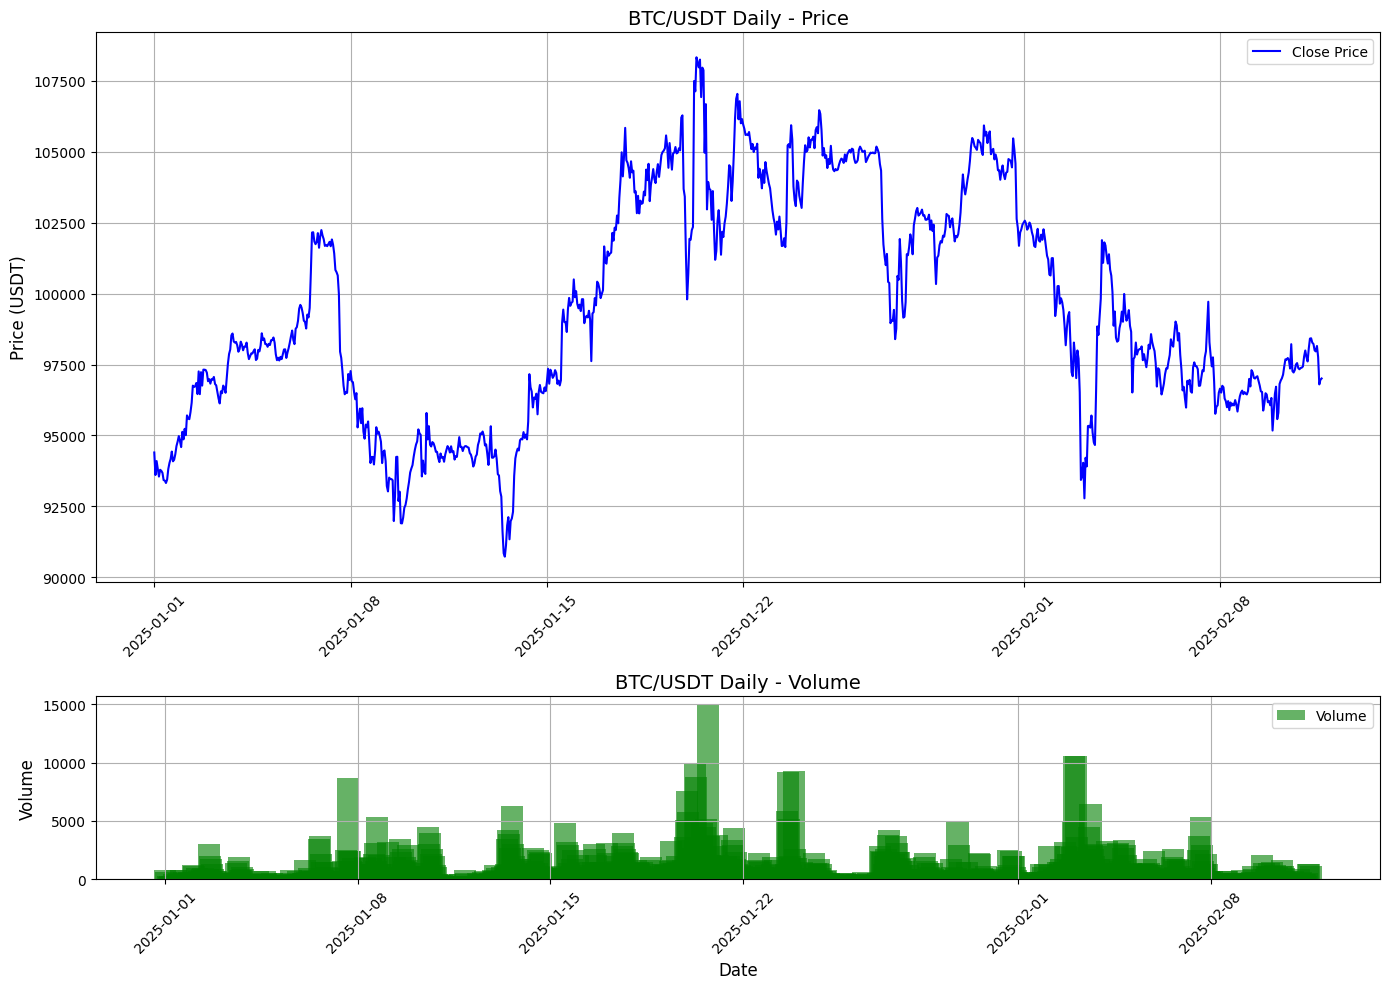

In [15]:
# Plot the daily BTC/USDT price and volume
if not fetch_historical_data.empty:
    plot_ohlcv(fetch_historical_data, 'BTC/USDT Daily')
else:
    print("No daily data to plot")



## Retrieving Order Book Data

The order book contains current buy and sell orders for a cryptocurrency trading pair. It represents the current market sentiment and liquidity, showing:

1. **Bids (Buy Orders)**: Orders from traders willing to buy at specific prices
2. **Asks (Sell Orders)**: Orders from traders willing to sell at specific prices
3. **Order Book Depth**: How many orders exist at each price level
4. **Spread**: The difference between the best bid and best ask price

Understanding the order book components:
- **Bid Price**: The price buyers are willing to pay
- **Ask Price**: The price sellers are willing to accept
- **Bid Volume**: The quantity of cryptocurrency that buyers want to purchase at a given price
- **Ask Volume**: The quantity of cryptocurrency that sellers want to sell at a given price

The order book provides valuable insights into market liquidity, potential support/resistance levels, and can help identify potential price movements based on order imbalances.

### Order Book Depth Control

When fetching order book data, you can use the `limit` parameter to control how many price levels you retrieve:

- **Default depth**: Exchanges typically return 100 price levels on each side
- **Custom depth**: You can request specific depth (e.g., limit=5, limit=20, limit=500)
- **Maximum depth**: Binance offers up to 5000 levels, but large values may impact performance
- **L1 data**: Setting limit=1 returns only the best bid and ask (useful for minimal data transfer)
- **L2 data**: Common depth values (5, 10, 20) provide a good balance between detail and performance
- **L3 data**: Deep order book (100+) reveals market microstructure but requires more bandwidth

Smaller limit values are useful for real-time applications, while deeper order books help with market analysis and visualization.



In [16]:
# Fetch the order book for BTC/USDT
order_book = cx.get_order_book('BTC/USDT')

print("\nOrder Book for BTC/USDT:")
print("--------------------------------------------------------")
print(order_book)

if not order_book['timestamp']:
    #print("No order book data available.")
    order_book['timestamp'] = time.time() * 1000  # Use current time if no timestamp is available

# Print some information about the order book
print(f"Order book timestamp: {datetime.fromtimestamp(order_book['timestamp']/1000)}")
print(f"Number of bids: {len(order_book['bids'])}")
print(f"Number of asks: {len(order_book['asks'])}")

print("\nTop 5 BTC/USDT Bids (Buy Orders):")
for price, amount in order_book['bids'][:5]:
    print(f"Price: ${price:.2f}, Amount: {amount:.6f} BTC, Total: ${price*amount:.2f}")

print("\nTop 5 BTC/USDT Asks (Sell Orders):")
for price, amount in order_book['asks'][:5]:
    print(f"Price: ${price:.2f}, Amount: {amount:.6f} BTC, Total: ${price*amount:.2f}")


Order Book for BTC/USDT:
--------------------------------------------------------
{'symbol': 'BTC/USDT', 'timestamp': 1747051553267.193, 'datetime': None, 'bids': [[103780.42, 2.04358], [103780.41, 0.00069], [103780.24, 6e-05], [103780.01, 0.00012], [103780.0, 0.01943]], 'asks': [[103780.43, 10.05197], [103780.49, 6e-05], [103780.66, 0.00295], [103780.79, 6e-05], [103781.59, 0.00018]], 'top_bid': [103780.42, 2.04358], 'top_ask': [103780.43, 10.05197], 'average_bid': 103780.216, 'average_ask': 103780.79199999999, 'spread': 0.00999999999476131, 'weighted_bid': 103780.41601357637, 'weighted_ask': 103780.4300907489}
Order book timestamp: 2025-05-12 17:35:53.267193
Number of bids: 5
Number of asks: 5

Top 5 BTC/USDT Bids (Buy Orders):
Price: $103780.42, Amount: 2.043580 BTC, Total: $212083.59
Price: $103780.41, Amount: 0.000690 BTC, Total: $71.61
Price: $103780.24, Amount: 0.000060 BTC, Total: $6.23
Price: $103780.01, Amount: 0.000120 BTC, Total: $12.45
Price: $103780.00, Amount: 0.019430 

### Visualizing the Order Book

In [17]:
def plot_order_book(order_book, depth=15):
    """Plot the order book with specified depth."""
    bids = order_book['bids'][:depth]
    asks = order_book['asks'][:depth]
    
    # Calculate cumulative volumes
    bid_prices = [bid[0] for bid in bids]
    bid_volumes = [bid[1] for bid in bids]
    bid_cumulative = [sum(bid_volumes[:i+1]) for i in range(len(bid_volumes))]
    
    ask_prices = [ask[0] for ask in asks]
    ask_volumes = [ask[1] for ask in asks]
    ask_cumulative = [sum(ask_volumes[:i+1]) for i in range(len(ask_volumes))]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot bids (buy orders)
    ax.bar(bid_prices, bid_volumes, width=bid_prices[0]*0.001, color='green', alpha=0.6, label='Bid Volume')
    ax.step(bid_prices, bid_cumulative, where='post', color='darkgreen', label='Bid Cumulative')
    
    # Plot asks (sell orders)
    ax.bar(ask_prices, ask_volumes, width=ask_prices[0]*0.001, color='red', alpha=0.6, label='Ask Volume')
    ax.step(ask_prices, ask_cumulative, where='post', color='darkred', label='Ask Cumulative')
    
    # Calculate the spread
    spread = ask_prices[0] - bid_prices[0]
    spread_percent = (spread / bid_prices[0]) * 100
    
    # Add title and labels
    ax.set_title(f'BTC/USDT Order Book (Spread: ${spread:.2f}, {spread_percent:.3f}%)', fontsize=14)
    ax.set_xlabel('Price (USDT)', fontsize=12)
    ax.set_ylabel('Amount (BTC)', fontsize=12)
    
    # Add legend and grid
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

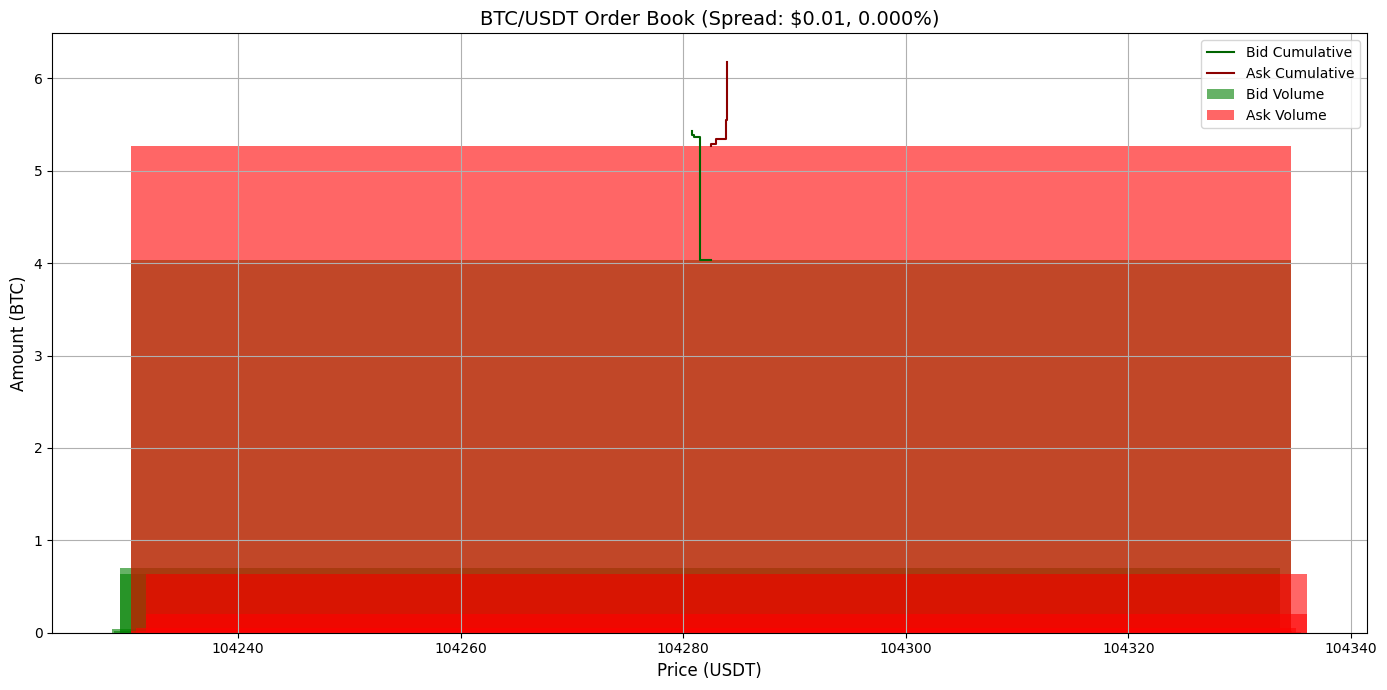

In [178]:
# Plot the order book for BTC/USDT
plot_order_book(order_book)

## Fetching Recent Trades

Let's get the most recent trades for a symbol.

Recent trades represent actual completed transactions between buyers and sellers on the exchange, whereas the order book shows pending orders that haven't been filled yet. Understanding their differences:

**Recent Trades:**
- Completed transactions that have already occurred
- Show the price, amount, and timestamp of executed orders
- Indicate market direction and activity (buyers vs sellers)
- Provide insight into recent price movements and volatility
- Help identify short-term trends and trading patterns

**Order Book:**
- Pending buy (bid) and sell (ask) orders waiting to be matched
- Shows market depth and available liquidity at different price levels
- Helps predict potential price movements based on buying/selling pressure
- Reveals support and resistance levels through order clustering
- The spread between highest bid and lowest ask indicates market liquidity

Analyzing both together gives you a comprehensive view of market conditions - trades show what has happened, while the order book shows what might happen next.

**Note on Trade Limits:**
- By default, exchanges typically return 100-500 recent trades
- You can specify the number of trades to retrieve using the `limit` parameter
- Binance allows retrieving up to 1000 recent trades per request and 500 is the default
- For more historical trades, you may need to use pagination with `since` parameter
- Trades are usually returned in descending order (newest first)

In [18]:
# Fetch recent trades for BTC/USDT
recent_trades = cx.get_trades('BTC/USDT', limit=20)

print(f"Retrieved {len(recent_trades)} recent trades",recent_trades)



# Display the DataFrame
#print(trades_df)

Retrieved 13 recent trades {'symbol': 'BTC/USDT', 'timestamp': Timestamp('2025-05-12 17:36:07.366000'), 'linux_timestamp': np.int64(1747051567366), 'buy':                  timestamp  linux_timestamp side      price   amount  \
6  2025-05-12 17:36:07.651    1747051567651  buy  103800.16  0.00005   
8  2025-05-12 17:36:07.866    1747051567866  buy  103800.16  0.06083   
10 2025-05-12 17:36:07.882    1747051567882  buy  103800.16  0.00481   
11 2025-05-12 17:36:08.046    1747051568046  buy  103800.16  0.00026   
12 2025-05-12 17:36:08.162    1747051568162  buy  103800.16  0.00025   
15 2025-05-12 17:36:08.239    1747051568239  buy  103800.16  0.09634   
16 2025-05-12 17:36:08.481    1747051568481  buy  103800.16  0.00039   

            cost         total          id  
6       5.190008      5.190008  3564531130  
8    6314.163733   6314.163733  3564531132  
10    499.278770    499.278770  3564531134  
11     26.988042     26.988042  3564531135  
12     25.950040     25.950040  3564531136 

## Understanding Kline vs Ticker Data

Kline (Candlestick) data and ticker data are two different ways to represent market information, each serving distinct purposes in trading analysis:

### Kline (Candlestick) Data
- **Time-based aggregation**: Represents price movement over specific time intervals (1m, 5m, 15m, 1h, etc.)
- **Contains OHLCV information**: Open, High, Low, Close prices and Volume for each period
- **Historical analysis**: Ideal for technical analysis, pattern recognition, and trend identification
- **Chart visualization**: Forms the basis of candlestick charts showing price action within periods
- **Retrieved via**: `fetch_ohlcv()` function in CCXT

### Ticker Data
- **Latest snapshot**: Represents the current market state at a specific moment
- **Real-time information**: Includes latest price, 24h statistics (high/low/volume), and bid/ask quotes
- **Market monitoring**: Best for watching current prices and market conditions
- **Immediate decisions**: Used for quick trading decisions based on latest market conditions
- **Retrieved via**: `fetch_ticker()` function in CCXT

### Key Differences
- Kline data shows price movement over time periods, while ticker data shows the current market snapshot
- Kline data is used for historical analysis and pattern recognition, ticker data for real-time monitoring
- Kline data requires specifying a timeframe, ticker data is always the latest information
- Kline data is typically visualized as candlestick charts, ticker data as single price points or tables

Both data types are essential for complete market analysis: klines for strategy development and technical analysis, tickers for execution timing and market monitoring.

## Conclusion

In this notebook, we've demonstrated how to use CCXT to:

1. Initialize the Binance exchange connection
2. Fetch current market data
3. Retrieve historical OHLCV data with various timeframes
4. Retrive the order book and trade data

These techniques form the foundation for more advanced cryptocurrency trading algorithms, market analysis tools, and automated trading bots.

## Further Resources

- [CCXT Official Documentation](https://ccxt.readthedocs.io/)
- [CCXT GitHub Repository](https://github.com/ccxt/ccxt)
- [Binance API Documentation](https://binance-docs.github.io/apidocs/)
- [Binance WebSocket API Documentation](https://binance-docs.github.io/apidocs/spot/en/#websocket-market-streams)